# Oxxo exploración y análisis

Esta es la cuarta y última parte de éste proyecto para la recuperación, limpieza, exploración y análisis de la distribución de las tiendas oxxo.

Por fines, quizás, de un público más interesado, éste notebook a diferencia de los otros contendrá explicaciones a lo largo del archivo en español.

Primero lo primero, importemos todo lo que necesitaremos y configuremos lo que se tenga que configurar

In [1]:
import pandas as pd
from geopy.distance import geodesic
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import networkx as nx
import geopandas as gpd
import folium
from shapely import points
from utils._03_OxxoCleaningOutliers import GetGeoDistance, GetClosestPoint
from utils._03_OxxoCleaningOutliers import ParserPointsPlotly, PlotPlottlyMapBox
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from scipy.stats import shapiro
import random

In [2]:
sns.set_theme(palette="bright")

### Cargando datos

Carguemos los datos que hemos estado procesando previamente, como recordatorio, aquellos incluyen información geográfica y de población sobre la ciudad de méxico. 

Ésta información fue descargada de la página oficial del gobierno la Ciudad de México ([datos cdmx](https://datos.cdmx.gob.mx/)) o cdmx, por lo que podremos confiar en ella. Algunos de los datos que contienen éstos archivos (formato geojson) son las coordenadas o localización de las figuras que conforman las alcaldías y algunas colonias, identificadores únicos de aquellos o la población de las alcaldías.

Por otro lado y muy importante, igual recordemos cargar la información propia de los oxxos (archivo csv) que contienen las coordenadas de los mismo y otros metadatos. La información está basada principalmente en la cdmx y parte de la zona metropolitana del valle de méxico.

Abajo verás en dos tablas cómo se ven éstos dos objetos ya cargados en python.

In [3]:
# Loading geographic information about mexico city
boroughs_cdmx_gdf = gpd.read_file("../data/oxxo/boroughs_cdmx.geojson")
boroughs_cdmx_gdf = boroughs_cdmx_gdf.rename_geometry("boroughs_geometry")
boroughs_cdmx_gdf.boroughs_name = boroughs_cdmx_gdf.boroughs_name.str.replace(".", "", regex=False)
boroughs_cdmx_gdf.boroughs_name = boroughs_cdmx_gdf.boroughs_name.str.replace("\s+"," ", regex=True)


neighborhoods_cdmx_gdf = gpd.read_file("../data/oxxo/neighborhoods_cdmx.geojson")
neighborhoods_cdmx_gdf = neighborhoods_cdmx_gdf.rename_geometry("neighborhoods_geometry")

cdmx_metadata_gdf = boroughs_cdmx_gdf.merge(neighborhoods_cdmx_gdf, on="index", how="inner")
cdmx_metadata_gdf.drop("index", axis=1, inplace=True)

cdmx_metadata_gdf.head()

boroughs_id boroughs_name  boroughs_population  \
0       09002  azcapotzalco               432205   
1       09002  azcapotzalco               432205   
2       09002  azcapotzalco               432205   
3       09002  azcapotzalco               432205   
4       09002  azcapotzalco               432205   

                                   boroughs_geometry neighborhoods_id  \
0  POLYGON ((-99.18231 19.50748, -99.18229 19.507...    0900200010383   
1  POLYGON ((-99.18231 19.50748, -99.18229 19.507...    0900200010379   
2  POLYGON ((-99.18231 19.50748, -99.18229 19.507...    090020001067A   
3  POLYGON ((-99.18231 19.50748, -99.18229 19.507...    0900200010699   
4  POLYGON ((-99.18231 19.50748, -99.18229 19.507...    0900200010260   

   neighborhoods_avg_income_quarterly  \
0                             34629.3   
1                             33061.7   
2                             44264.7   
3                             47045.3   
4                             59562.1   

                              neighborhoods_geometry  
0  POLYGON ((-99.15142 19.47910, -99.15152 19.478...  
1  POLYGON ((-99.15813 19.47749, -99.15824 19.477...  
2  POLYGON ((-99.18126 19.47366, -99.18115 19.473...  
3  POLYGON ((-99.17616 19.46819, -99.17657 19.467...  
4  POLYGON ((-99.19685 19.49267, -99.19640 19.492...

In [4]:
# Loading clean oxxo data
oxxo_df = pd.read_csv("../data/oxxo/oxxo_clean_data.csv")
oxxo_df["Subregion"] = oxxo_df.Subregion.str.replace(".", "", regex=False)
oxxo_df["Subregion"] = oxxo_df.Subregion.str.replace("\s+"," ", regex=True)

oxxo_df.head(2)

latitude  longitude           name  comments  rating  \
0  19.353753 -99.189937  OXXO Helenico       4.0     4.3   
1  19.348316 -99.185520    Oxxo La Paz      13.0     3.5   

                               Address Neighborhood           City  Postal  \
0                   Avenida Revolución     Sn Ángel  Guadalupe Inn  1020.0   
1  Avenida Miguel Ángel de Quevedo 36B          NaN    Chimalistac  1050.0   

        Subregion            Region  Bajo  Medio Bajo  Medio Alto  Alto  
0  alvaro obregon  ciudad de méxico   NaN       104.0        80.0  24.0  
1  alvaro obregon  ciudad de méxico   NaN       104.0        80.0  24.0

### Distancia mínima entre dos oxxos

Si exploraste el notebook anterior (*03_OxxoCleaningOutliers.ipynb*) probablemente ya estés un poco familiarizado con lo que se hará aquí, si no es así y, de manera breve, aquí se calculan las distancias entre todos los oxxo y luego se determina qué pares de tiendas están más cercanas entre sí. Ésto es lo que se observa en el data frame de abajo (o la tabla de abajo) cuyas columnas están nombradas como __point_a__, __point_b__, __index_a__, __index_b__, __distance__ o bien, ésta misma información resumida en *Fig.1*

Como adelanto, si observas la *Fig.1*, te darás cuenta que ¡Hay montón de oxxos repartidos a lo largo de la ciudad! Bien dicen por ahí que hay un oxxo en cada esquina, pues bien, falso falso ésto no parece ser...   

In [5]:
# Getting matrix distance
oxxo_points_numpy = oxxo_df[["latitude","longitude"]].to_numpy()

matrix_distance_oxxo = GetGeoDistance(oxxo_points_numpy)
np.fill_diagonal(matrix_distance_oxxo, np.inf)

In [6]:
# Getting closest points
oxxo_closest_distance = GetClosestPoint(oxxo_points_numpy, matrix_distance_oxxo)
oxxo_closest_distance

point_a                    point_b  index_a  index_b  \
0     (19.3537529, -99.1899374)  (19.3519153, -99.1869152)        0      126   
1     (19.3483164, -99.1855199)    (19.351655, -99.185903)        1      107   
2     (19.3416291, -99.2030682)  (19.3394322, -99.2038138)        2       16   
3     (19.3609272, -99.1852465)  (19.3599485, -99.1831651)        3       11   
4     (19.3580665, -99.1844114)  (19.3599485, -99.1831651)        4       11   
...                         ...                        ...      ...      ...   
1665   (19.4093558, -99.120045)  (19.4078033, -99.1214175)     1665      932   
1666  (19.4151761, -99.1042633)  (19.4172241, -99.1026671)     1666     1388   
1667  (19.2631302, -99.1053816)  (19.2604749, -99.1111195)     1667     1114   
1668  (19.2739901, -99.1241512)  (19.2743458, -99.1206057)     1668     1669   
1669  (19.2743458, -99.1206057)  (19.2772486, -99.1220439)     1669     1072   

        distance  
0     377.104110  
1     371.756224  
2     255.496556  
3     244.044214  
4     246.063624  
...          ...  
1665  224.312447  
1666  281.959476  
1667  671.006107  
1668  374.771276  
1669  355.114174  

[1670 rows x 5 columns]

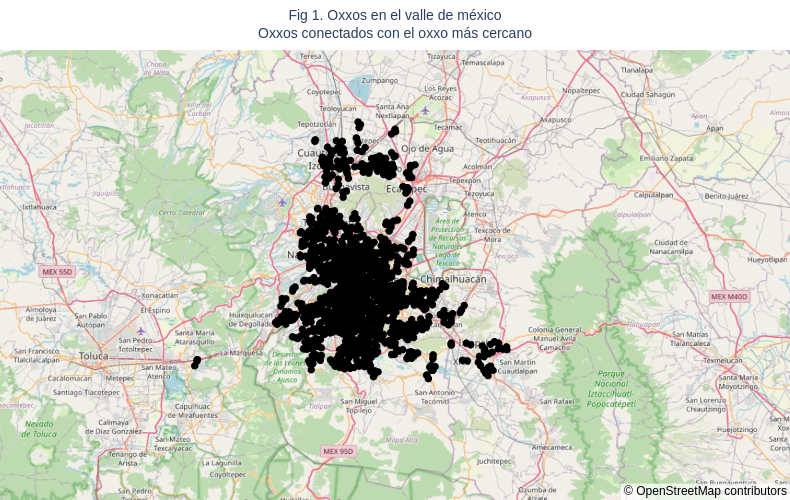

In [7]:
latitude, longitude, distance = ParserPointsPlotly(oxxo_closest_distance.point_a,
                    oxxo_closest_distance.point_b,
                    oxxo_closest_distance.distance)

oxxo_map = PlotPlottlyMapBox(longitude, latitude, distance)
oxxo_map.update_layout(
    title="Fig 1. Oxxos en el valle de méxico<br>Oxxos conectados con el oxxo más cercano",
    font={"size":10},
    title_x=0.5,
    title_y=0.96,
    margin={"l": 0, "r": 0, "b": 0, "t": 50},
    height=500
)

oxxo_map.show()

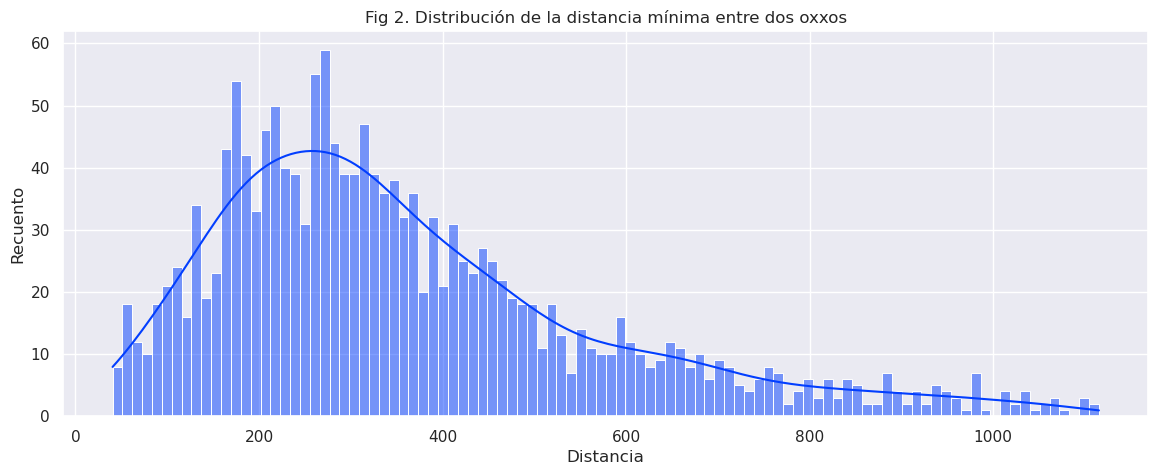

In [8]:
fig, axis = plt.subplots(1,1, figsize=(14,5))
sns.histplot(oxxo_closest_distance.distance, kde=True, bins=100, ax=axis)

axis.set_title("Fig 2. Distribución de la distancia mínima entre dos oxxos")
axis.set_xlabel("Distancia")
axis.set_ylabel("Recuento")

plt.show()

In [9]:
oxxo_closest_distance.distance.describe()

count    1670.000000
mean      363.854741
std       213.341883
min        40.407969
25%       210.848744
50%       313.328076
75%       463.828876
max      1115.078610
Name: distance, dtype: float64

In [10]:
oxxo_closest_distance.distance.quantile(0.9)

671.2890232342353

Ya entrando un poquito en un campo más "técnico", 75% de los oxxos se encuentran a una distancia de entre 40 metros a 463 metros, y 90% de aquellos de 40 a 671 metros (*Fig 2*). Recordemos que la distancia mínima y máxima fue truncada a 40 metros y 1125 metros (con la pérdida del 7.11% de información, para más detalles puedes checar *03_OxxoCleaningOutliers.ipynb*).

Así mismo, la distancia mínima entre dos oxxos en la ciudad de méxico y parte del valle de méxico corresponde usualmente a 313 metros (mediana 313.32 metros) o aproximadamente a una distancia caminable de 5 minutos entre oxxos (1 kilometro = 15 minutos)

### Conexiones entre oxxos

Si conectamos cada uno de éstos oxxos por su distancia mínimo con respecto a otras sucursales, podremos construir un grafo conformado por muchos otros pequeños grafos conectados (componentes conectados). La *fig 1* muestra parte de ésto, ¿Cuál es el comportamiento general de aquellas conexiones?

In [11]:
oxxo_points_index = oxxo_closest_distance[["index_a", "index_b"]].to_numpy()
oxxo_graph = nx.Graph()
oxxo_graph.add_edges_from(oxxo_points_index)

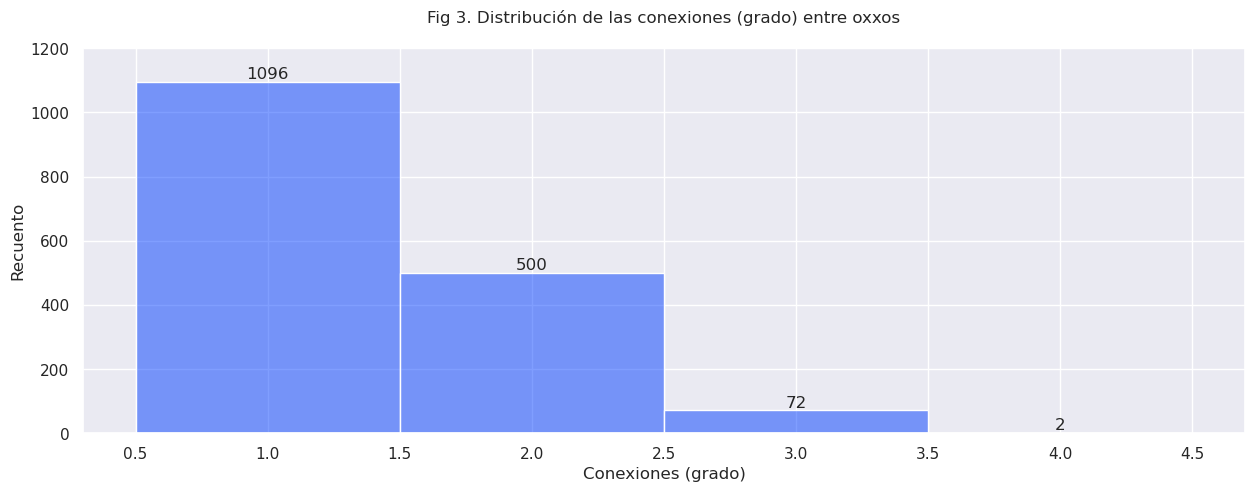

In [12]:
degrees = dict(oxxo_graph.degree).values()

fig, axis = plt.subplots(1,1, figsize=(15,5))
sns.histplot(degrees, discrete=True, legend=False, ax=axis)

axis.bar_label(axis.containers[1])
axis.set_title("Fig 3. Distribución de las conexiones (grado) entre oxxos\n")
axis.set_ylim(0, 1200)
axis.set_xlabel("Conexiones (grado)")
axis.set_ylabel("Recuento")

plt.show()

Basado en que tenemos información de 1670 tiendas y lo mostrados en *Fig 3*. Alrededor del 65.62% de los oxxos en el valle de méxico (cdmx y parte de la zona metropolitana del valle de méxico) están conectados sólo a otro oxxo, así mismo, casi 30% de los oxxos están conectados a dos oxxos. Encontrar una tienda que esté conectada ya sea a 3 o 4 oxxos no es algo común y, por ende, oxxos actuando como tiendas centrales conectadas a muchas tiendas parece algo raro, al menos, bajo sus conexiones entre distancias mínimas.

In [13]:
weight = np.column_stack([oxxo_points_index,
                          np.array(oxxo_closest_distance.distance)])

oxxo_graph.add_weighted_edges_from(weight)

In [14]:

degree_df = pd.DataFrame(oxxo_graph.degree(), columns=["node","degree"])
weight_df = pd.DataFrame(oxxo_graph.degree(weight="weight"), columns=["node", "weight"])

degree_weight_df = degree_df.merge(weight_df, how="inner", on="node")

degree_weight_df["avg_distance"] = degree_weight_df.weight / degree_weight_df.degree

degree_weight_df.head()

node  degree       weight  avg_distance
0     0       2   864.319234    432.159617
1   126       2   487.289012    243.644506
2     1       1   371.756224    371.756224
3   107       2   481.941126    240.970563
4     2       2  1043.734428    521.867214

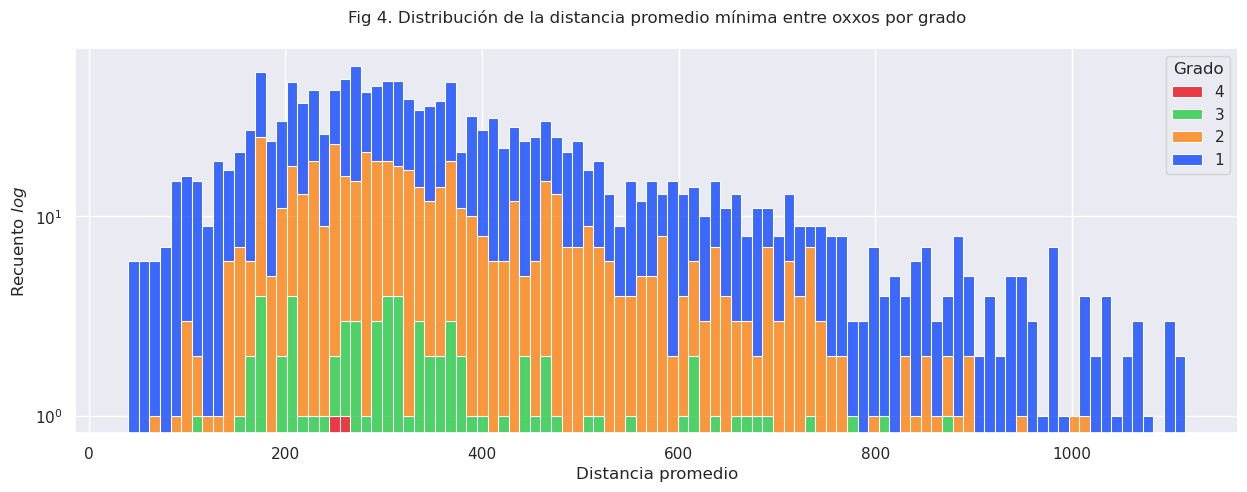

In [15]:
colors = sns.palettes.color_palette("bright", 4)

fig, axis = plt.subplots(1,1, figsize=(15,5))

sns.histplot(data=degree_weight_df, x="avg_distance",
                 hue="degree", multiple="stack", 
                 palette=colors, ax=axis, bins=100, legend=False)

axis.set_ylabel("Recuento $log$")
axis.set_xlabel("Distancia promedio")

axis.set_yscale("log")
axis.set_title("Fig 4. Distribución de la distancia promedio mínima entre oxxos por grado\n")

axis.legend(title='Grado', loc='best', labels=['4', '3', "2", "1"])

plt.show()

Así mismo, el comportamiento de las distancias entre oxxos es similar (*Fig 4*) en términos de sus conexiones (grado) siempre y cuando una tienda tiene una, o dos tiendas más cerca de aquel (< 1125 metros). En cambio, si una tienda tiene una conexión con más de tres oxxos, es una tendencia más difícil de discutir.

### Probabilidades de encontrar un oxxo

Por otro lado, ¿Cuál es la probabilidad de que haya N oxxos "cerca" de otro oxxo? Vamos a probarlo para diferentes definiciones de "cerca" (1000, 800, 600, 400 metros)

In [16]:
def GetDistribution(matrix_distance:np.array,
                    threshold:int|float,
                    prob:bool=False) -> pd.DataFrame:
    
    sample_size = matrix_distance.shape[0] 
    
    positive_cases = (matrix_distance < threshold).nonzero()
    positive_cases = np.transpose(positive_cases)
    
    weights = matrix_distance[positive_cases[:,0], positive_cases[:,1]]
    
    edges = np.column_stack((positive_cases, weights))

    g = nx.Graph()
    g.add_weighted_edges_from(edges)

    degrees_df = pd.DataFrame(g.degree(), columns=["node", "degree"])
    distribution = degrees_df.degree.value_counts().to_frame()
    
    distribution.reset_index(names=["case"], inplace=True)
    distribution.rename({"degree":"positive_cases"}, axis=1, inplace=True)

    n_negative_cases = sample_size - distribution.positive_cases.sum()

    negative_cases_df = pd.DataFrame({"case": [0], "positive_cases": n_negative_cases})

    distribution = pd.concat([negative_cases_df, distribution]).sort_values(by="case")
    
    if prob:
        
        distribution.positive_cases = distribution.positive_cases / sample_size
    
    return(g, distribution.reset_index(drop=True))

In [17]:
distributions_per_dist = []
graphs = []
close_def = [1000, 800, 600, 400]

for close in close_def:
    g, df = GetDistribution(matrix_distance_oxxo, close, True)
    
    graphs.append(g)
    distributions_per_dist.append(df)
    

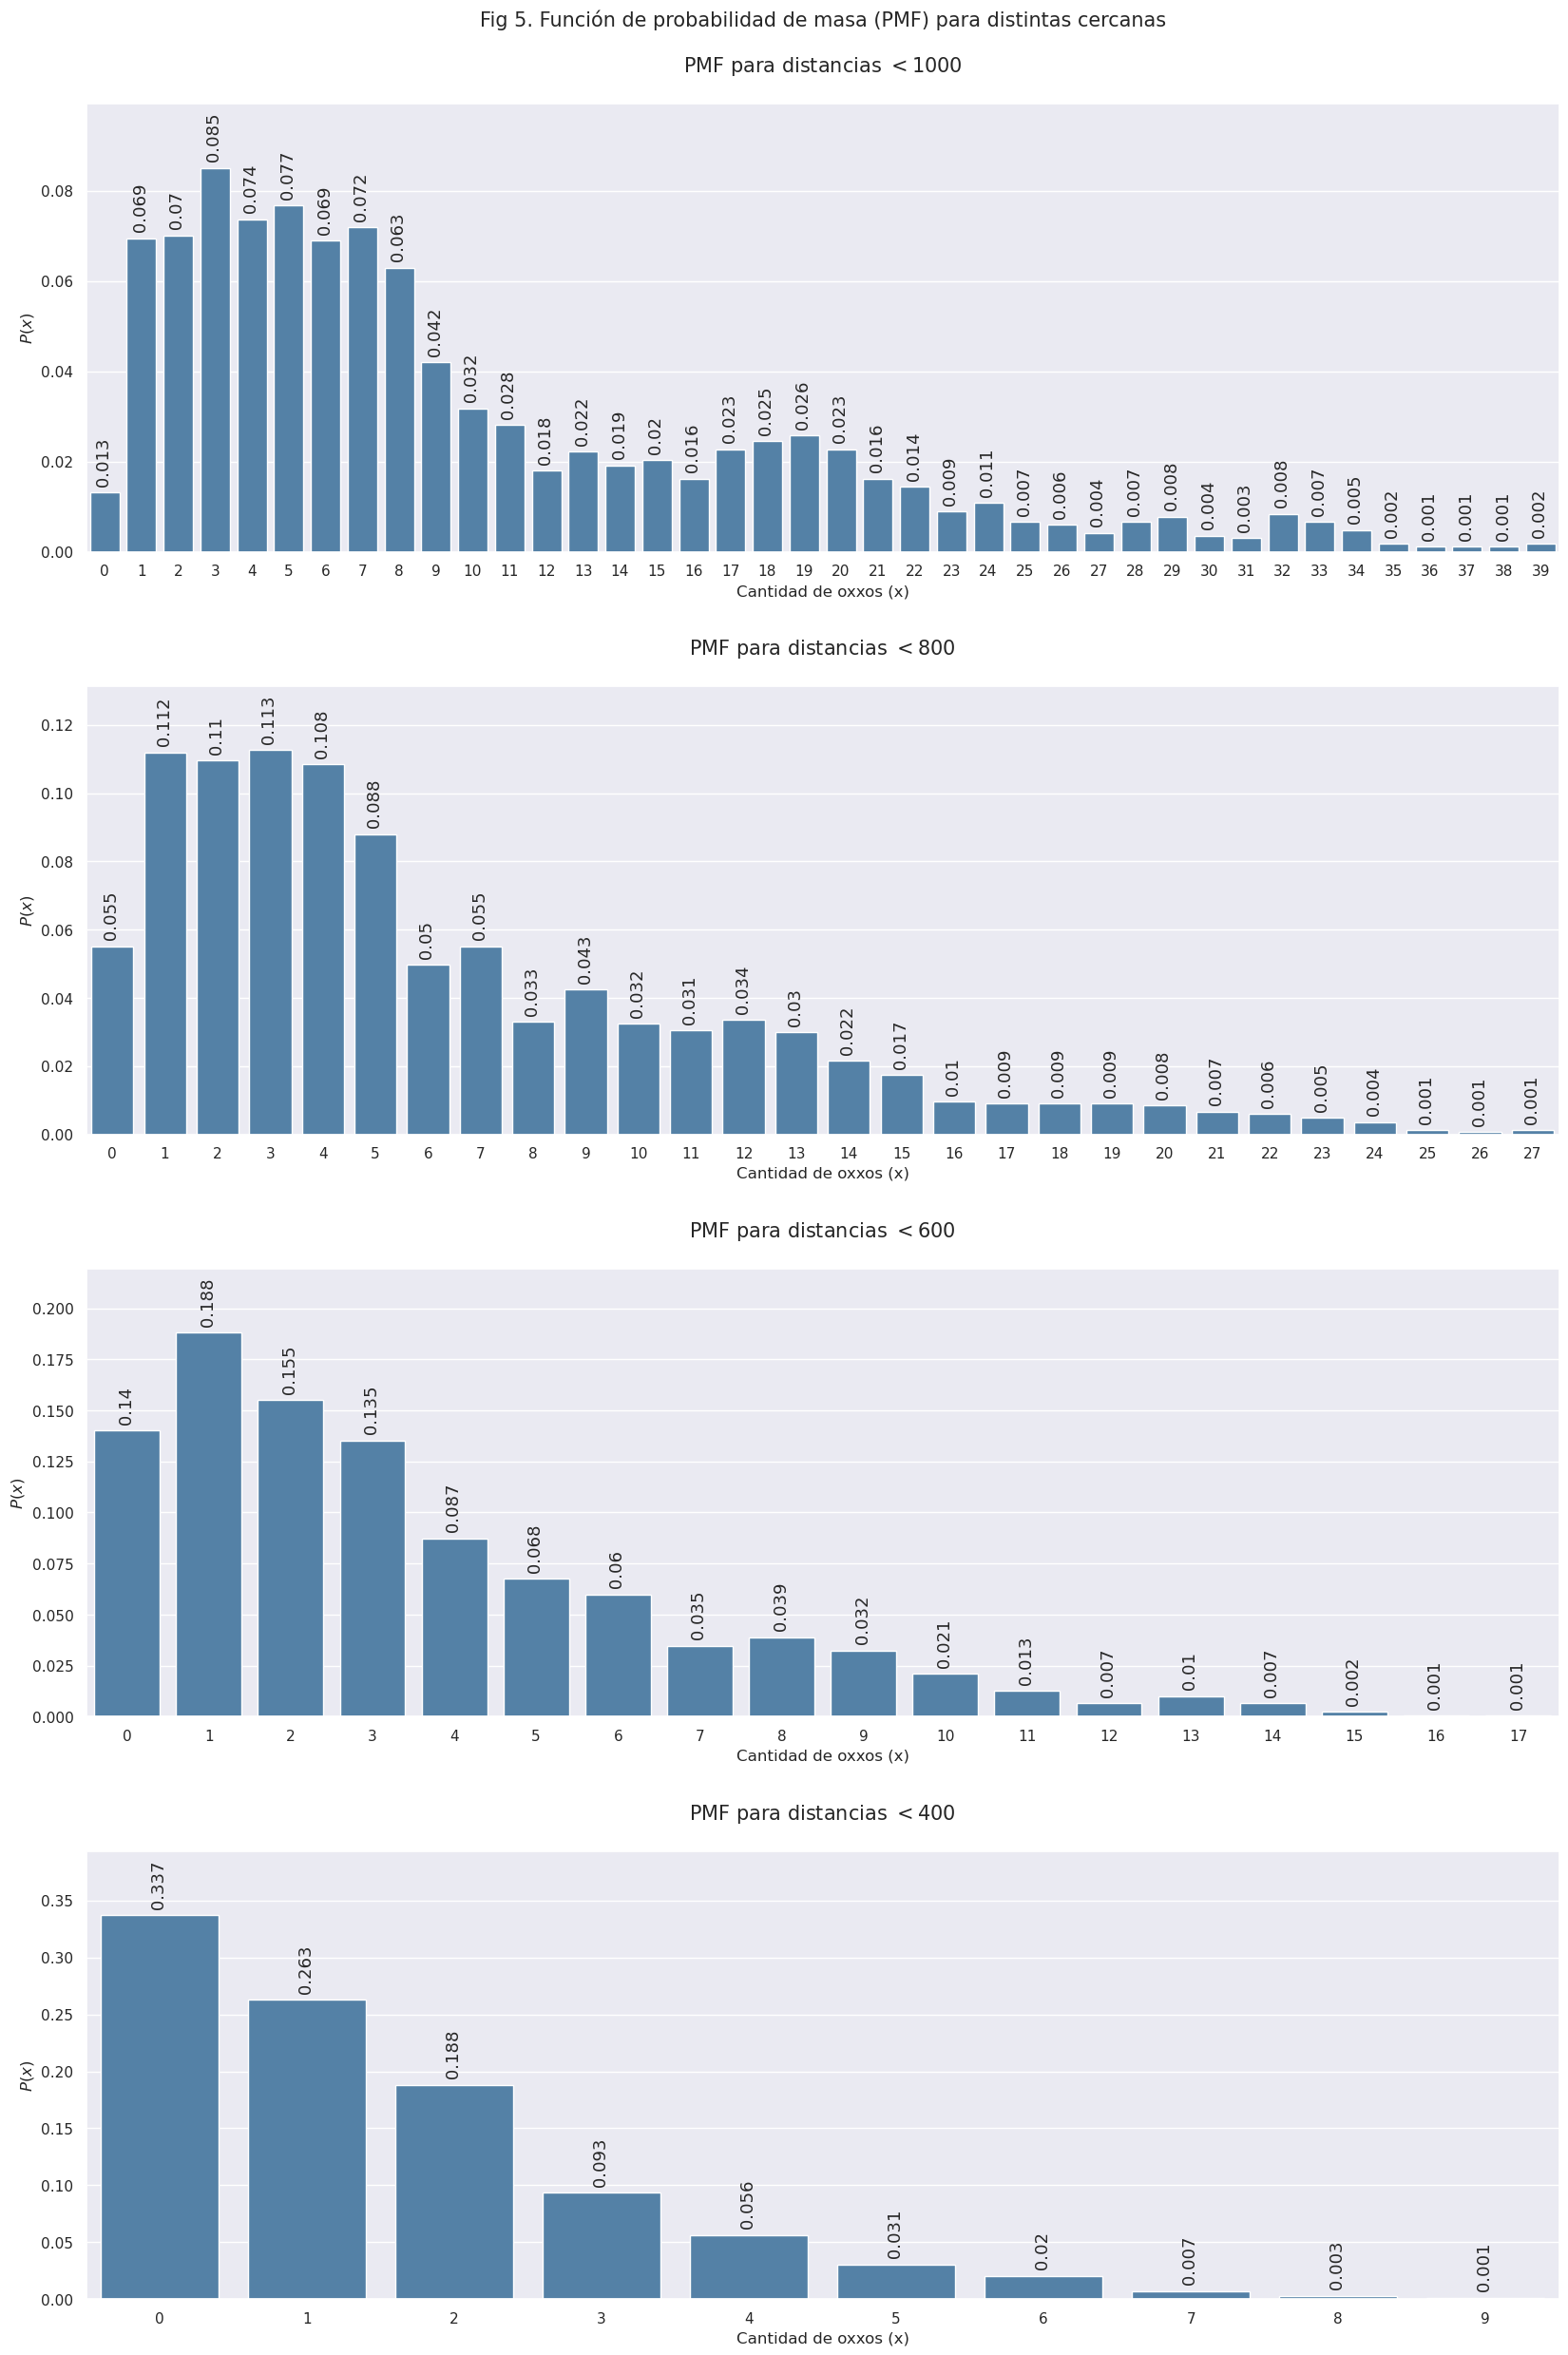

In [18]:
fig, axis = plt.subplots(4,1, figsize=(20,30))

for df, dist, ax in zip(distributions_per_dist, close_def, axis):
    
    sns.barplot(x = df["case"], y = df["positive_cases"],
                ax = ax, color="steelblue")
    
    top_limit = df["positive_cases"].max() + (df["positive_cases"].max() / 6)
    ax.set_ylim(0, top_limit)
    ax.set_title(f"PMF para distancias $< {dist}$\n", fontsize=15)
    
    labels = [" " + str(round(i,3)) for i in ax.containers[0].datavalues]
    ax.bar_label(ax.containers[0], labels=labels, fmt="%.3f", fontsize=13, rotation=90)
    ax.set_ylabel("$P(x)$")
    ax.set_xlabel("Cantidad de oxxos (x)")

axis[0].set_title(f"Fig 5. Función de probabilidad de masa (PMF) para distintas cercanas\n\nPMF para distancias $< {close_def[0]}$\n", fontsize=15 )
plt.subplots_adjust(hspace=0.3)
plt.show()

La *Fig 5* muestra diferentes probabilidades que, si estés parado en un oxxo, haya n cantidad de otros oxxos cerca. Por ejemplo, si consideramos como una distancia cercana un radio de 400 metros (*Fig 5* - PFM para distancias < 400), la probabilidad de que haya dos oxxos a igual o menor distancia es de 0.188 o 18.8%, mientras que la probabilidad de que haya al menos tres oxxos es la suma cumulativa para $1,2 \text{ y } 3$, o $0.263 + 0.188 + 0.093 = 0.544$

Sorprendentemente, si consideramos un radio de 1000 metros, ¡Obtenemos probabilidades para hasta 39 oxxos cerca! Muy baja, pero no cero. Una probabilidad de 0.001 de nuestro espacio muestral de 1670 oxxos corresponderían a tres tiendas aproximadamente que, en un radio de 1000 metros, colindan con 39 oxxos (estos oxxos correspondieron a tres ubicados en la alcaldía Cuauhtémoc por el centro histórico. No mostrado).

Como es esperado, a definiciones más estrictas de "cercanía" la probabilidad de que haya n oxxos en la distancia especificada se vuelve raro.

### Mejor/Peor oxxo

Otra pregunta que surge con respecto a nuestras tiendas sería, ¿Cuál es el peor y el mejor oxxo de entre todos nuestros datos? Para ello se obtuvieron el top 5 y lo peores 5 basados en su calificación general encontrada en google maps ponderada por el número de *reviews*. De ésta manera, a mayor número de *reviews* en los que se basa la calificación, más confiable será ésta.

El *score* obtenido va de un rango de 0 a 5. Un *score* de 0 en una sucursal significa que no tiene *reviews* y; por ende, tampoco tiene calificación. De antemano aquellos oxxos sin *reviews*, al saber que no aportan información, fueron eliminados. Por otro lado, un score de 5, significa que tiene muy buena calificación general y, que además, éstas están apoyadas por un gran número de *reviews*.

In [19]:
# Removing NaN
mask_nan = ~oxxo_df[["rating","comments"]].isna().any(axis=1)

oxxo_scores_df = oxxo_df[mask_nan][["rating","comments"]]
oxxo_scores_df["comments_rank_score"] = oxxo_scores_df.comments.rank(pct=True)
oxxo_scores_df["oxxo_score"] = oxxo_scores_df["rating"] * oxxo_scores_df["comments_rank_score"]

oxxo_scores_df = oxxo_scores_df.sort_values(by="oxxo_score", ascending=False)
top_five = oxxo_scores_df.head()

buttom_five = oxxo_scores_df.sort_values(by="oxxo_score").head()

columns_to_drop = ["Neighborhood", "Postal",
                   "Bajo","Medio Bajo",
                   "Medio Alto","Alto",
                   "Address", "City", 
                   "Subregion", "Region", 
                   "comments_x","rating_x",
                   "comments_rank_score"]

rename = {"name": "Name",
        "oxxo_score": "Score",
        "comments_y": "Reviews",
        "rating_y": "Rating",
        "address": "Address",
        "latitude": "Latitude",
        "longitude": "Longitude"}

top_five = oxxo_df.loc[top_five.index].merge(top_five, left_index=True, right_index=True)
address_top_five = top_five[["Address", "City", "Subregion", "Region"]].fillna("NaN")
address_top_five = address_top_five.apply(lambda x: ", ".join(x), axis=1)

top_five["address"] = address_top_five.values
top_five.drop(columns_to_drop, inplace=True, axis=1)
top_five.rename(rename, axis=1, inplace=True)

buttom_five = oxxo_df.loc[buttom_five.index].merge(buttom_five, left_index=True, right_index=True)
address_buttom_five = buttom_five[["Address", "City", "Subregion", "Region"]].fillna("")
address_buttom_five = address_buttom_five.apply(lambda x: ", ".join(x), axis=1)

buttom_five["address"] = address_buttom_five.values
buttom_five.drop(columns_to_drop, inplace=True, axis=1)
buttom_five.rename(rename, axis=1, inplace=True)

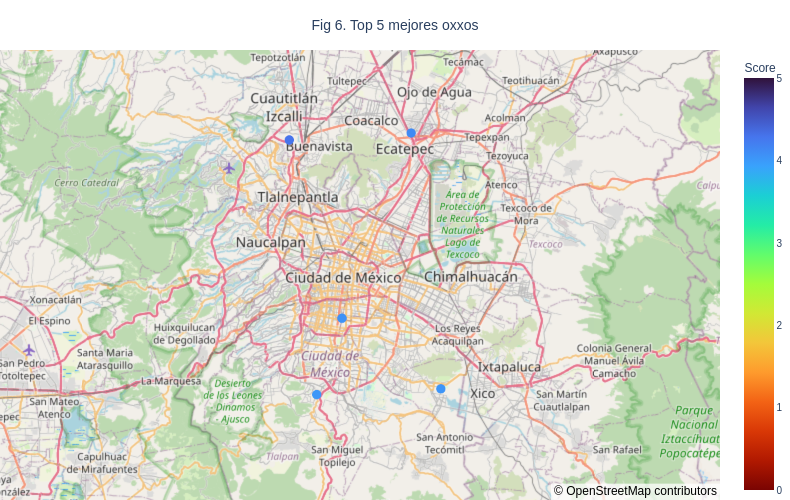

In [20]:
top_five_fig = px.scatter_mapbox(data_frame = top_five, mapbox_style="open-street-map",
                                 lat="Latitude", lon="Longitude",
                                 hover_data=list(top_five.columns), color="Score",
                                 color_continuous_scale="turbo_r", range_color=[0,5])

top_five_fig.update_traces(marker={"size":10})
top_five_fig.update_layout(
    title="Fig 6. Top 5 mejores oxxos",
    font={"size":10},
    title_x=0.5,
    title_y=0.96,
    margin={"l": 0, "r": 0, "b": 0, "t": 50},
    height=500,
    mapbox={"zoom":9}
)
top_five_fig.show()

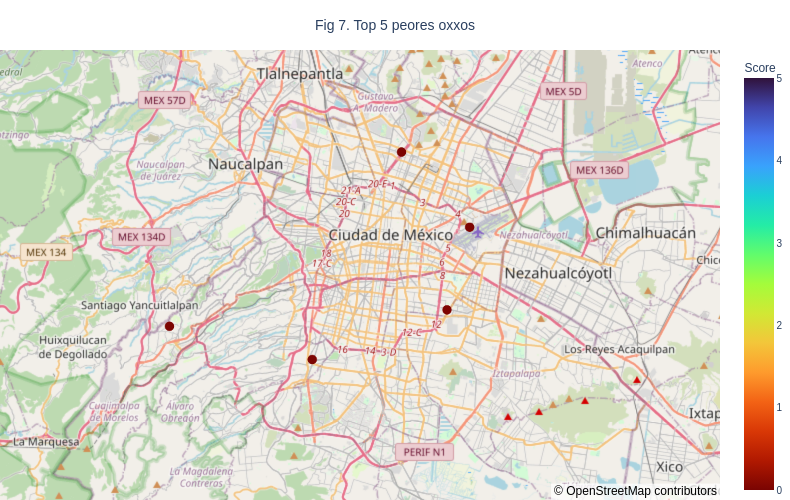

In [21]:
buttom_five_fig = px.scatter_mapbox(data_frame = buttom_five, mapbox_style="open-street-map",
                                 lat="Latitude", lon="Longitude",
                                 hover_data=list(buttom_five.columns), color="Score",
                                 color_continuous_scale="turbo_r", range_color=[0,5])

buttom_five_fig.update_traces(marker={"size":10})
buttom_five_fig.update_layout(
    title="Fig 7. Top 5 peores oxxos",
    font={"size":10},
    title_x=0.5,
    title_y=0.96,
    margin={"l": 0, "r": 0, "b": 0, "t": 50},
    height=500,
    mapbox={"zoom":10}
)

buttom_five_fig.show()

La *Fig.6* y *Fig.7* muestran la locación de los mejores 5 y los peores 5 (o al menos cuya calificación general no pudieramos confiar) oxxos respectivamente.

Del top 5, el mejor oxxo es la sucursal "Cedis Oxxo San Martín Obispo" ubicada en Cuautitlán Izcalli (latitude=19.609915, longitude=-99.207047) en el Estado de México con un *score* de 4.2919 con una calificación general de 4.3 basado en 858 *reviews*. Le siguen la sucursal "Oxxo Plaza Oriente" (latitude=19.618948, longitude=-99.039759) con un *score* de 4.1158, "Oxxo" (latitude=19.379142;longitude=-99.134699) con 4.054, "Oxxo Laguna" (19.287718; -98.998942) con 4.0351 y "OXXO" (19.280273;-99.169367) con 4.016.

Por otro lado, de los peores oxxos, cuatro tiendas empataron con un score de 0.012 con una calificación de 1 basado en 1 *review*. La quinta tienda corresponde a "Oxxo carrizo" con un *score* de 0.024 con dos de calificación y un *review*

### Densidad de oxxos

En ésta parte exploraremos la densidad de oxxos. Debido a la disponibilidad de información geográfica con respecto a la cdmx. Nos enfocaremos principalmente en ésta mas que a la zona metropolitana.

In [22]:
cdmx_boroughs_df = cdmx_metadata_gdf.iloc[:,:4].drop_duplicates()

cdmx_boroughs_area = cdmx_boroughs_df.boroughs_geometry.to_crs("EPSG:32614").area
cdmx_boroughs_area = cdmx_boroughs_area / (1000 * 1000)

cdmx_boroughs_df["area_km2"] = cdmx_boroughs_area.values

oxxo_boroughs_cdmx = oxxo_df.merge(cdmx_boroughs_df,
                                   how="right",
                                   right_on="boroughs_name",
                                   left_on="Subregion")

oxxo_boroughs_cdmx.head()

latitude  longitude                name  comments  rating  \
0  19.478012 -99.200186       OXXO Cantemoc      10.0     2.8   
1  19.470469 -99.189791                Oxxo      15.0     3.8   
2  19.484479 -99.185800    Oxxo Castilla MR      34.0     2.9   
3  19.478852 -99.189039       OXXO Apolonia      17.0     3.1   
4  19.481556 -99.182440  Oxxo San Sebastián      14.0     3.4   

                  Address Neighborhood                    City  Postal  \
0          Campo Cantemoc          NaN             San Antonio  2720.0   
1  Avenida Aquiles Serdán          NaN           Ángel Zimbrón  2099.0   
2    Avenida Azcapotzalco          NaN  Centro de Azcapotzalco  2000.0   
3          Santa Apolonia          NaN  San Francisco Tetecala  2730.0   
4                 Calle 2          NaN             Del Maestro  2040.0   

      Subregion            Region  Bajo  Medio Bajo  Medio Alto  Alto  \
0  azcapotzalco  ciudad de méxico   NaN        40.0        47.0  23.0   
1  azcapotzalco  ciudad de méxico   NaN        40.0        47.0  23.0   
2  azcapotzalco  ciudad de méxico   NaN        40.0        47.0  23.0   
3  azcapotzalco  ciudad de méxico   NaN        40.0        47.0  23.0   
4  azcapotzalco  ciudad de méxico   NaN        40.0        47.0  23.0   

  boroughs_id boroughs_name  boroughs_population  \
0       09002  azcapotzalco               432205   
1       09002  azcapotzalco               432205   
2       09002  azcapotzalco               432205   
3       09002  azcapotzalco               432205   
4       09002  azcapotzalco               432205   

                                   boroughs_geometry   area_km2  
0  POLYGON ((-99.18231 19.50748, -99.18229 19.507...  33.496385  
1  POLYGON ((-99.18231 19.50748, -99.18229 19.507...  33.496385  
2  POLYGON ((-99.18231 19.50748, -99.18229 19.507...  33.496385  
3  POLYGON ((-99.18231 19.50748, -99.18229 19.507...  33.496385  
4  POLYGON ((-99.18231 19.50748, -99.18229 19.507...  33.496385

In [23]:
columns_density = ["boroughs_name", "boroughs_population", "area_km2"]
density_oxxo_df = oxxo_boroughs_cdmx[columns_density]
density_oxxo_df = density_oxxo_df.groupby(columns_density).value_counts().to_frame().reset_index()

density_oxxo_df.rename({0:"n_oxxo"}, inplace=True, axis=1)

density_oxxo_df["oxxo_density_area"] = density_oxxo_df.n_oxxo / density_oxxo_df.area_km2
density_oxxo_df["oxxo_density_population_100k"] = density_oxxo_df.n_oxxo / density_oxxo_df.boroughs_population
density_oxxo_df["oxxo_density_population_100k"] = density_oxxo_df.oxxo_density_population_100k * 100_000

density_oxxo_df.head()

boroughs_name  boroughs_population   area_km2  n_oxxo  \
0         alvaro obregon               759137  95.819633     101   
1           azcapotzalco               432205  33.496385      67   
2          benito juarez               434153  26.680071     162   
3               coyoacan               614447  53.879871      98   
4  cuajimalpa de morelos               217686  71.102696      31   

   oxxo_density_area  oxxo_density_population_100k  
0           1.054064                     13.304581  
1           2.000216                     15.501903  
2           6.071948                     37.314034  
3           1.818861                     15.949301  
4           0.435989                     14.240695

In [24]:
polygon_cdmx = cdmx_boroughs_df[["boroughs_name", "boroughs_geometry"]]
density_oxxo_df = density_oxxo_df.merge(polygon_cdmx, on="boroughs_name")

density_oxxo_df = gpd.GeoDataFrame(density_oxxo_df)
density_oxxo_df = density_oxxo_df.set_geometry("boroughs_geometry")

In [25]:
rename = {"boroughs_name":"Alcaldía", "boroughs_population":"Población",
          "area_km2":"Área in $km^2$","n_oxxo":"Cantidad de Oxxos",
          "oxxo_density_area":"Densidad por área",
          "oxxo_density_population_100k":"Densidad por 100k habitantes"}

density_oxxo_df.rename(rename, axis=1, inplace=True)
density_oxxo_df.head()

Alcaldía  Población  Área in $km^2$  Cantidad de Oxxos  \
0         alvaro obregon     759137       95.819633                101   
1           azcapotzalco     432205       33.496385                 67   
2          benito juarez     434153       26.680071                162   
3               coyoacan     614447       53.879871                 98   
4  cuajimalpa de morelos     217686       71.102696                 31   

   Densidad por área  Densidad por 100k habitantes  \
0           1.054064                     13.304581   
1           2.000216                     15.501903   
2           6.071948                     37.314034   
3           1.818861                     15.949301   
4           0.435989                     14.240695   

                                   boroughs_geometry  
0  POLYGON ((-99.18906 19.39559, -99.18871 19.394...  
1  POLYGON ((-99.18231 19.50748, -99.18229 19.507...  
2  POLYGON ((-99.14762 19.40401, -99.14681 19.403...  
3  POLYGON ((-99.13427 19.35654, -99.13397 19.356...  
4  POLYGON ((-99.25738 19.40112, -99.25698 19.400...

In [26]:
density_km2_fig = density_oxxo_df.explore("Densidad por área", legend=True,
                                     style_kwds={"fillOpacity":0.8}, cmap="magma",
                                     vmin=0, vmax=10,
                                     zoom_start=9)

title_text = "Fig 8. Densidad de oxxos por km^2"
title_format = '''
        <h4 align="center" style="font-size:14px"><b>{}</b></h4>
        '''.format(title_text)

density_km2_fig.get_root().html.add_child(folium.Element(title_format))
density_km2_fig

In [27]:
density_popu_fig = density_oxxo_df.explore("Densidad por 100k habitantes", legend=True,
                                      style_kwds={"fillOpacity":0.8}, cmap="copper",
                                      vmin=0,  vmax=40,
                                      zoom_start=9)

title_text = "Fig 8. Densidad de oxxos por 100k habitantes"
title_format = '''
        <h4 align="center" style="font-size:14px"><b>{}</b></h4>
        '''.format(title_text)

density_popu_fig.get_root().html.add_child(folium.Element(title_format))
density_popu_fig

En la *Fig.8* podemos ver la densidad por $km^2$ de los oxxos. De ésta manera, la zona con mayor número de oxxos es la alcaldía Cuauhtémoc, con 6.55 sucursales por $km^2$ (¿Recuerdan que les mencioné que aquí se encontraban los 3 oxxos que colindan con 39 oxxos?) o 213 tiendas, seguido por Benito Juárez con 6.07 tiendas por $km^2$ o 162 establecimientos. La zona con menos oxxos corresponde a la alcaldía de Milpa Alta con 0.0033 puestos por $km^2$

Curiosamente, en Milpa Alta sólo nos encontramos con un oxxo, aunque bien, existe la posibilidad que al remover outliers algunos de éstos se fueron. De cualquier manera, es un comportamiento interesante.

Mientras tanto, bajo la perspectica de densidad de oxxos por cada 100,000 habitantes, nuevamente la alcaldía Cuauhtémoc y Benito Juárez tienen ma la mayor cantidad de oxxos, con 39.01 y 37.71 tiendas por cada 100 mil habitantes

### Oxxo correlaciones

Algo que resalta a la vista es la pregunta ¿Hay algún tipo de relación entre la cantidad de oxxos con respecto a su ubicación geográfica? Más espécificamente, con respecto al tamaño de la población en las alcaldías, al área de cada demarcación o al ingreso promedio por colonia.

Hagamos unas gráficas para revisar.

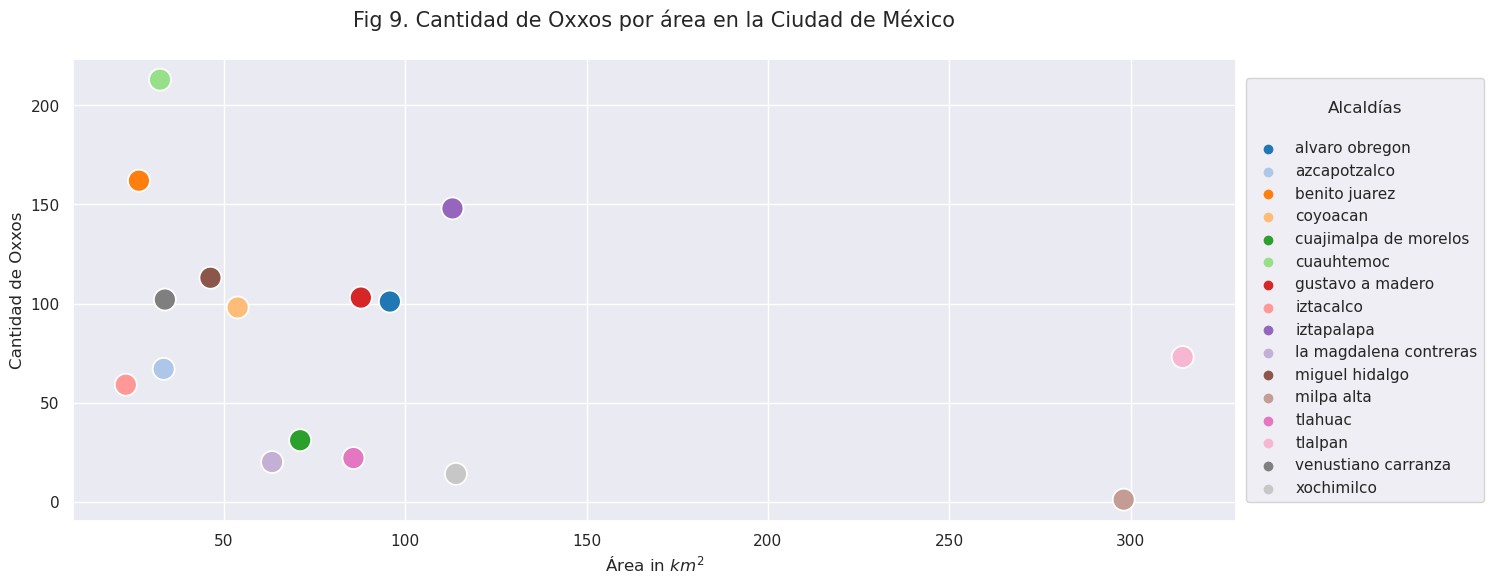

In [28]:
fig, axis = plt.subplots(1,1, figsize=(15,6))

colors = sns.color_palette("tab20", n_colors=16)

sns.scatterplot(density_oxxo_df, x="Área in $km^2$",
                y="Cantidad de Oxxos", hue="Alcaldía",
                ax=axis, s=250, palette=colors)

axis.legend(loc="center right", bbox_to_anchor=(1.22, 0.5), title="\nAlcaldías\n")
axis.set_title("Fig 9. Cantidad de Oxxos por área en la Ciudad de México\n", fontsize=15)
plt.show()

Data la gráfica anterior, no parece haber una relación en cuanto a la cantidad de oxxos por $km^2$. Lo más cercano a tratar de ajustar una línea con éstos datos pareciera ser más como a una función de tipo "_Power law_"

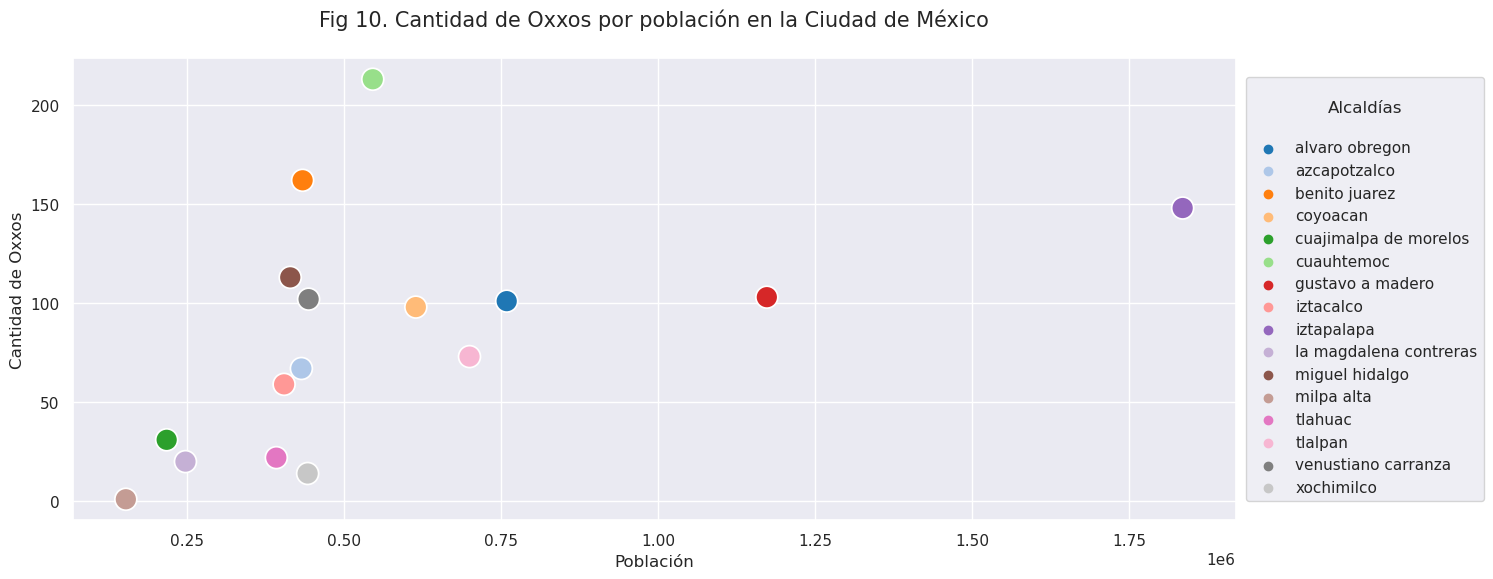

In [29]:
fig, axis = plt.subplots(1,1, figsize=(15,6))

sns.scatterplot(density_oxxo_df, x="Población",
                y="Cantidad de Oxxos", hue="Alcaldía",
                ax=axis, s=250, palette=colors)

axis.legend(loc="center right", bbox_to_anchor=(1.22, 0.5), title="\nAlcaldías\n")

axis.set_title("Fig 10. Cantidad de Oxxos por población en la Ciudad de México\n", fontsize=15)
plt.show()

Aquí ya se empieza a ver un poco una relación lineal entre los datos, aunque todavía algo dispersa, sobre todo por las alcaldías de Gustavo a. Madero e Iztapalapa o por las alcaldías de Benito Juarez y la Cuauhtemoc, dependiendo de qué consideres como "atípico". En mi caso, si eliminaramos la Cuauhtémoc y Benito Juárez, podríamos tener una buena relación lineal.

In [30]:
density_oxxo_df_droped = density_oxxo_df.drop([2,5])

density_oxxo_df_droped[["Población", "Cantidad de Oxxos"]].corr()

Población  Cantidad de Oxxos
Población           1.000000           0.745748
Cantidad de Oxxos   0.745748           1.000000

Si eliminamos las dos alcaldías mencionadas, esta relación tiene además un valor de $r=0.745$ (correlación de pearson), donde, valores mayores de 0.7, son usualmente considerados como una fuerte correlación entre las variables. Tiene sentido, ¿Por qué no colocar más tiendas donde hay más población? De ésta manera, más clientela potencial y/o abasteces de manera proporcional a ella.

¿Qué hay sobre la densidad de población por $km^2$? Si hay una fuerte correlación entre población y la cantidad de oxxos, debería igual serlo por la densidad de población

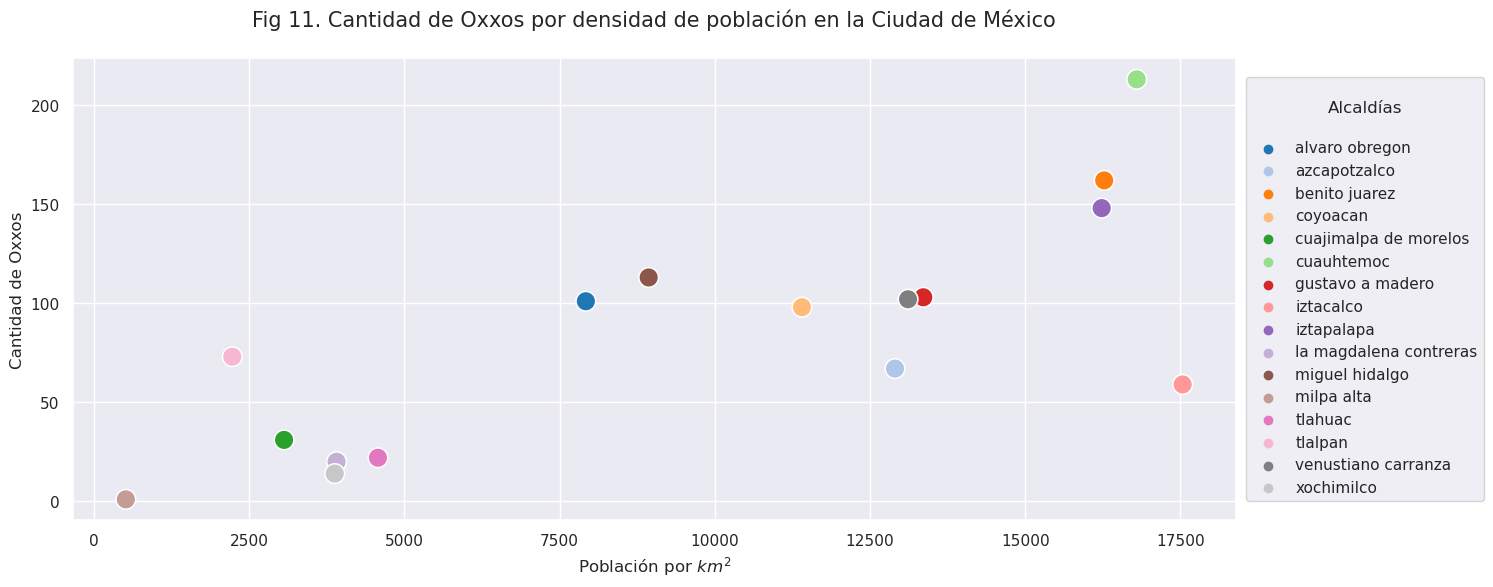

In [31]:
density_oxxo_df["Población por $km^2$"] = density_oxxo_df.Población / density_oxxo_df["Área in $km^2$"]

fig, axis = plt.subplots(1,1, figsize=(15,6))

sns.scatterplot(density_oxxo_df, x="Población por $km^2$",
                y="Cantidad de Oxxos", hue="Alcaldía",
                ax=axis, s=200, palette=colors)

axis.legend(loc="center right", bbox_to_anchor=(1.22, 0.5), title="\nAlcaldías\n")

axis.set_title("Fig 11. Cantidad de Oxxos por densidad de población en la Ciudad de México\n", fontsize=15)
plt.show()

In [32]:
density_oxxo_df[["Cantidad de Oxxos","Población por $km^2$"]].corr()

Cantidad de Oxxos  Población por $km^2$
Cantidad de Oxxos              1.000000              0.766176
Población por $km^2$           0.766176              1.000000

Aquí, la correlación es un poco más fuerte ($r=0.766$), y no hubo necesidad de eliminar las dos alcaldías

Dado lo anterior, podríamos intentar ajustar un modelo de regresión lineal para predecir la cantidad de tiendas que habrá en un determinado sitio, pero un problema obvio es cuando hablemos de extensiones territoriales relativamente más grandes. Por ejemplo, con la información de abajo sobre la Ciudad de México

In [33]:
cdmx_pop = density_oxxo_df["Población"].sum()
cdmx_area= density_oxxo_df["Área in $km^2$"].sum()
cdmx_den = cdmx_pop / cdmx_area

print(f'cdmx población: {cdmx_pop}')
print(f'área cdmx km²: {cdmx_area}')
print(f'densidad por km²:{cdmx_den}')
print(f'Total oxxos: {density_oxxo_df["Cantidad de Oxxos"].sum()}')

cdmx población: 9209944
área cdmx km²: 1493.1292931727419
densidad por km²:6168.216002533741
Total oxxos: 1327


Por definición tomando la población por $km^2$, la cdmx debería tener alrededor de 100 tiendas oxxo, cuando la realidad es que aquel dato debería ser cercano a los 1327

Sin embargo, quizás con información puramente de la población o sumado con otras variables podríamos obtener un modelo relativamente bueno.

In [34]:
simple_reg_data = density_oxxo_df[["Población", "Cantidad de Oxxos"]]

simple_reg_data = simple_reg_data.rename({"Población":"pop",
                                          "Cantidad de Oxxos":"y"}, axis=1)


x_test_cdmx = pd.DataFrame([cdmx_pop], columns=["pop"])

simple_reg_model = smf.ols("y ~ pop", data = simple_reg_data).fit()

print(f"y predict: {simple_reg_model.predict(x_test_cdmx).values}")

y predict: [669.18134408]


In [35]:
print(simple_reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.227
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     4.102
Date:                Sat, 08 Apr 2023   Prob (F-statistic):             0.0623
Time:                        18:31:28   Log-Likelihood:                -85.398
No. Observations:                  16   AIC:                             174.8
Df Residuals:                      14   BIC:                             176.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     43.8546     23.521      1.865      0.0

/home/lromero/mambaforge/envs/DataScience/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1772: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=16



A pesar de que la variable independiente es significativa (P>|t| = 0.002), no lo hizo tan bien al predecir con respecto a toda la ciudad de méxico. Era algo de esperarse, nuestras observaciones sólo están acotadas a nivel de alcaldías. Veamos si haciendo un tipo de *data augmentation* introduciendo nuevos datos por cada dos alcaldías, tres, etc. Mejora la predicción conservando la significancia. 

Para tratar de salir del intervalo de valores acotados por cada alcaldía individual, crearemos nuevos datos usando mínimo 5 alcaldías aleatoriamente para general 5 nuevos datos para alimentar la regresión.

In [36]:
# Min 5 and Max 14 districts will be taken at the same time

options = np.arange(5,17,1)
new_values = pd.DataFrame(columns=["pop", "y"])

for i in range(5):
    
    n_sample = random.choice(options)
    value_sample = simple_reg_data.sample(n_sample).sum().to_frame().T
    new_values = pd.concat([new_values, value_sample])

In [37]:
simple_reg_data_ext = pd.concat([simple_reg_data, new_values])
simple_reg_data_ext = simple_reg_data_ext.astype("int64")

In [38]:
simple_reg_model_ext = smf.ols("y ~ pop", data = simple_reg_data_ext).fit()

print(f"y predict: {simple_reg_model_ext.predict(x_test_cdmx).values}")

y predict: [1348.33300133]


In [39]:
print(simple_reg_model_ext.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     777.3
Date:                Sat, 08 Apr 2023   Prob (F-statistic):           7.08e-17
Time:                        18:31:29   Log-Likelihood:                -118.24
No. Observations:                  21   AIC:                             240.5
Df Residuals:                      19   BIC:                             242.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.2537     19.148      0.170      0.8

Esto nos da un modelo con mejores resultados y nuestra variable aún es significativa, los residuos muestran que no hay suficiente evidencia para rechazar que los datos no siguen una distribución normal ($Prob(Omnibus) > 0.05;\ Prob(JB) > 0.05$). Haremos una prueba de shapiro para confirmar, recordemos que la hipótesis nula es 

$$H_0: \text{Los valores provienen de una distribución normal}$$

$$H_1: \text{Los valores NO provienen de una distribución normal}$$

In [40]:
shapiro(simple_reg_model_ext.resid)

ShapiroResult(statistic=0.9446734189987183, pvalue=0.26916319131851196)

Dado el valor p > 0.05 en la prueba de shapiro, nuevamente, no podemos rechazar la hipótesis nula que nuestros datos no difieren de una distribución normal. Por otro lado, con respecto al supuesto de homocedasticidad...

In [41]:
#Hypothesis
# H_0: Homoscedasticity is present.
# H_a: Homoscedasticity is not present (i.e. heteroscedasticity exists)

breusch_pagan = sms.het_breuschpagan(simple_reg_model_ext.resid,
                                     simple_reg_model_ext.model.exog)

breusch_pagan = {"lm":breusch_pagan[0],
           "lm_pvalue":breusch_pagan[1],
           "fvalue":breusch_pagan[2],
           "f_pvalue":breusch_pagan[3]}

breusch_pagan

{'lm': 0.5723520322167821,
 'lm_pvalue': 0.4493257923010857,
 'fvalue': 0.5323514791947425,
 'f_pvalue': 0.4745197513125944}

Con un $p_{value} > 0.05$ no hay suficiente evidencia para rechazar la hipótesis nula, o lo que es, homocedasticidad está presente. Por ende, podemos tomar como válido nuestro modelo de regresión.

Una cosa a notar es el alto $R^2$, donde nuestro modelo es capaz de explicar más del 90% de la variabilidad de nuestra variable dependiente. Aunque bien, en la realidad, el criterio para decidir dónde abrir una nueva tienda debería ser más complicado que basarse sólo en el tamaño de la población, por ende, el modelo debería ser tomado con precaución al sacar conclusiones de éste.

La linea con el mejor ajuste junto con sus coeficientes son mostrados abajo *Fig.12*

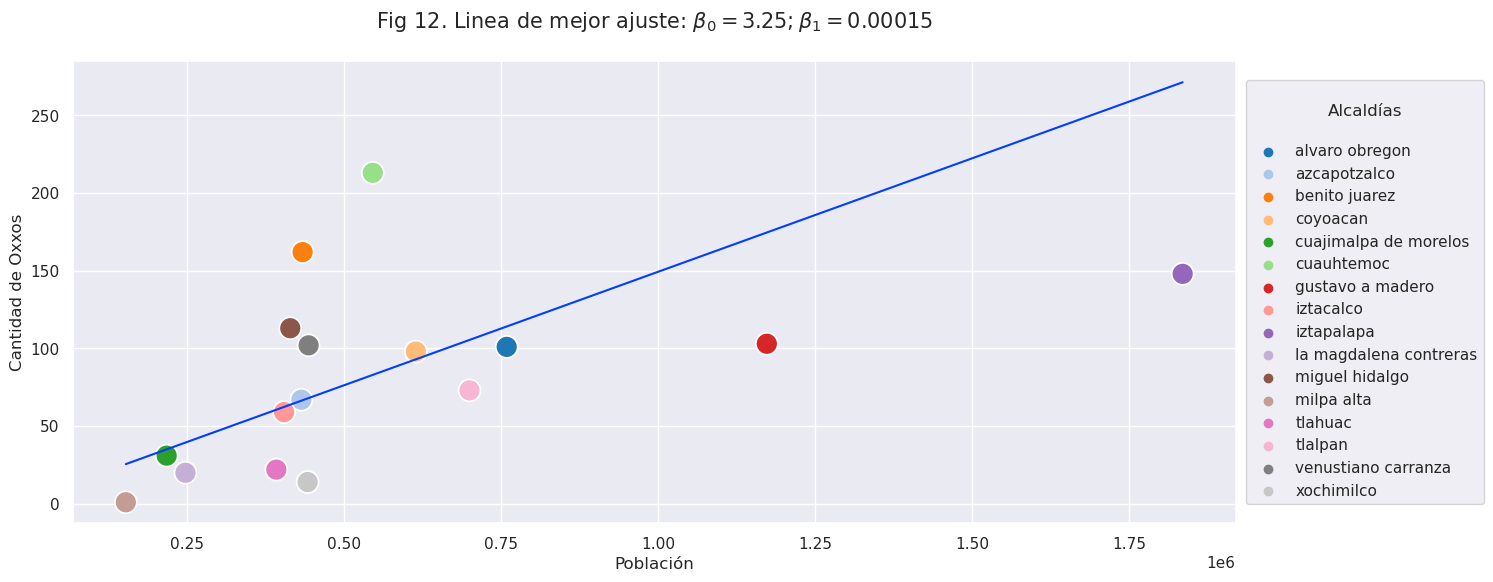

In [42]:
X = density_oxxo_df.Población.to_frame()
X.rename({"Población": "pop"}, axis=1, inplace=True)

intercept, coef = simple_reg_model_ext.params
intercept, coef = round(intercept, 2), round(coef, 5)

model_predict = simple_reg_model_ext.predict(X).values

fig, axis = plt.subplots(1,1, figsize=(15,6))

sns.scatterplot(density_oxxo_df, x="Población",
                y="Cantidad de Oxxos", hue="Alcaldía",
                ax=axis, s=250, palette=colors)

sns.lineplot(x=X.to_numpy().reshape(-1,), y=model_predict, ax=axis)

axis.legend(loc="center right", bbox_to_anchor=(1.22, 0.5), title="\nAlcaldías\n")
axis.set_title(f"Fig 12. Linea de mejor ajuste: $\\beta_0={intercept}; \\beta_1={coef}$\n",
               fontsize=15)
plt.show()

Por otro lado, ¿Hay una relación entre el ingreso por hogar con respecto a la cantidad de oxxos en un determinado lugar? Cruzaremos ésta información con la los oxxos, puedes saltarte las siguientes líneas de código e irte directamente a la *Fig.13* y *Fig.14* si lo deseas

In [43]:
oxxo_points_object = points(oxxo_df[["longitude","latitude"]].to_numpy())
neighborhoods_id = []

for point_oxxo in oxxo_points_object:
    check_point_loc = cdmx_metadata_gdf.neighborhoods_geometry.contains(point_oxxo)
    
    check_point_loc = check_point_loc.to_numpy().nonzero()[0]
    
    if check_point_loc.size == 0:
        neighborhoods_id.append(np.NaN)
    else:
        index_neighborhoods = cdmx_metadata_gdf.iloc[check_point_loc[0],:].neighborhoods_id
        neighborhoods_id.append(index_neighborhoods)

oxxo_df["neighborhoods_id"] = neighborhoods_id

oxxo_income_neighborhoods = oxxo_df.merge(cdmx_metadata_gdf, on="neighborhoods_id", how="inner")

oxxo_income_neighborhoods = oxxo_income_neighborhoods[["latitude", 
                                                       "longitude",
                                                       "neighborhoods_avg_income_quarterly",
                                                       "neighborhoods_id",
                                                       "neighborhoods_geometry",
                                                       "boroughs_name"]]

oxxo_income_neighborhoods = gpd.GeoDataFrame(oxxo_income_neighborhoods)
oxxo_income_neighborhoods = oxxo_income_neighborhoods.set_geometry("neighborhoods_geometry")
oxxo_income_neighborhoods.head()

latitude  longitude  neighborhoods_avg_income_quarterly neighborhoods_id  \
0  19.353753 -99.189937                             96111.9    0901000011059   
1  19.351915 -99.186915                             96111.9    0901000011059   
2  19.348316 -99.185520                            112677.0    0901000011129   
3  19.341629 -99.203068                            123502.0    090100001110A   
4  19.348656 -99.201853                            123502.0    090100001110A   

                              neighborhoods_geometry   boroughs_name  
0  POLYGON ((-99.18425 19.35745, -99.18470 19.356...  alvaro obregon  
1  POLYGON ((-99.18425 19.35745, -99.18470 19.356...  alvaro obregon  
2  POLYGON ((-99.18514 19.34834, -99.18603 19.347...  alvaro obregon  
3  POLYGON ((-99.20074 19.35158, -99.20091 19.350...  alvaro obregon  
4  POLYGON ((-99.20074 19.35158, -99.20091 19.350...  alvaro obregon

In [44]:
area = gpd.GeoSeries(oxxo_income_neighborhoods.neighborhoods_geometry).to_crs("EPSG:32614")
area = area.area / (1000 * 1000)

oxxo_income_neighborhoods["area $km^2$"] = area

oxxo_income_copy = oxxo_income_neighborhoods.drop("neighborhoods_geometry", axis=1)

oxxo_income_groups = oxxo_income_copy.groupby("neighborhoods_id").size()
oxxo_income_groups = oxxo_income_groups.reset_index().rename({0:"Cantidad de oxxos"}, axis=1)

oxxo_income_copy = oxxo_income_copy.drop(["latitude","longitude"], axis=1)
oxxo_income_copy = oxxo_income_copy.drop_duplicates()

n_oxxo_neighborhoods = oxxo_income_copy.merge(oxxo_income_groups,
                                              on="neighborhoods_id",
                                              how="inner")

n_oxxo_neighborhoods = n_oxxo_neighborhoods.merge(oxxo_income_neighborhoods[["neighborhoods_id",
                                                                             "neighborhoods_geometry"]],
                                                  on="neighborhoods_id",
                                                  how="inner")

n_oxxo_neighborhoods = gpd.GeoDataFrame(n_oxxo_neighborhoods).drop_duplicates()
n_oxxo_neighborhoods = n_oxxo_neighborhoods.set_geometry("neighborhoods_geometry")
n_oxxo_neighborhoods = n_oxxo_neighborhoods.reset_index(drop=True)

n_oxxo_neighborhoods["Cantidad de oxxos esperados por $km^2$"] = n_oxxo_neighborhoods["Cantidad de oxxos"] \
                                                       / n_oxxo_neighborhoods["area $km^2$"]

n_oxxo_neighborhoods["Ingreso mensual promedio por hogar"] = n_oxxo_neighborhoods["neighborhoods_avg_income_quarterly"] / 3
n_oxxo_neighborhoods.head()

neighborhoods_avg_income_quarterly neighborhoods_id   boroughs_name  \
0                             96111.9    0901000011059  alvaro obregon   
1                            112677.0    0901000011129  alvaro obregon   
2                            123502.0    090100001110A  alvaro obregon   
3                             95006.0    0901000010987  alvaro obregon   
4                            110846.0    0901000011203  alvaro obregon   

   area $km^2$  Cantidad de oxxos  \
0     0.471572                  2   
1     0.506502                  1   
2     0.629744                  2   
3     0.455965                  3   
4     0.312282                  3   

                              neighborhoods_geometry  \
0  POLYGON ((-99.18425 19.35745, -99.18470 19.356...   
1  POLYGON ((-99.18514 19.34834, -99.18603 19.347...   
2  POLYGON ((-99.20074 19.35158, -99.20091 19.350...   
3  POLYGON ((-99.18913 19.36301, -99.18867 19.363...   
4  POLYGON ((-99.19032 19.33868, -99.19210 19.338...   

   Cantidad de oxxos esperados por $km^2$  Ingreso mensual promedio por hogar  
0                                4.241138                        32037.300000  
1                                1.974325                        37559.000000  
2                                3.175894                        41167.333333  
3                                6.579455                        31668.666667  
4                                9.606716                        36948.666667

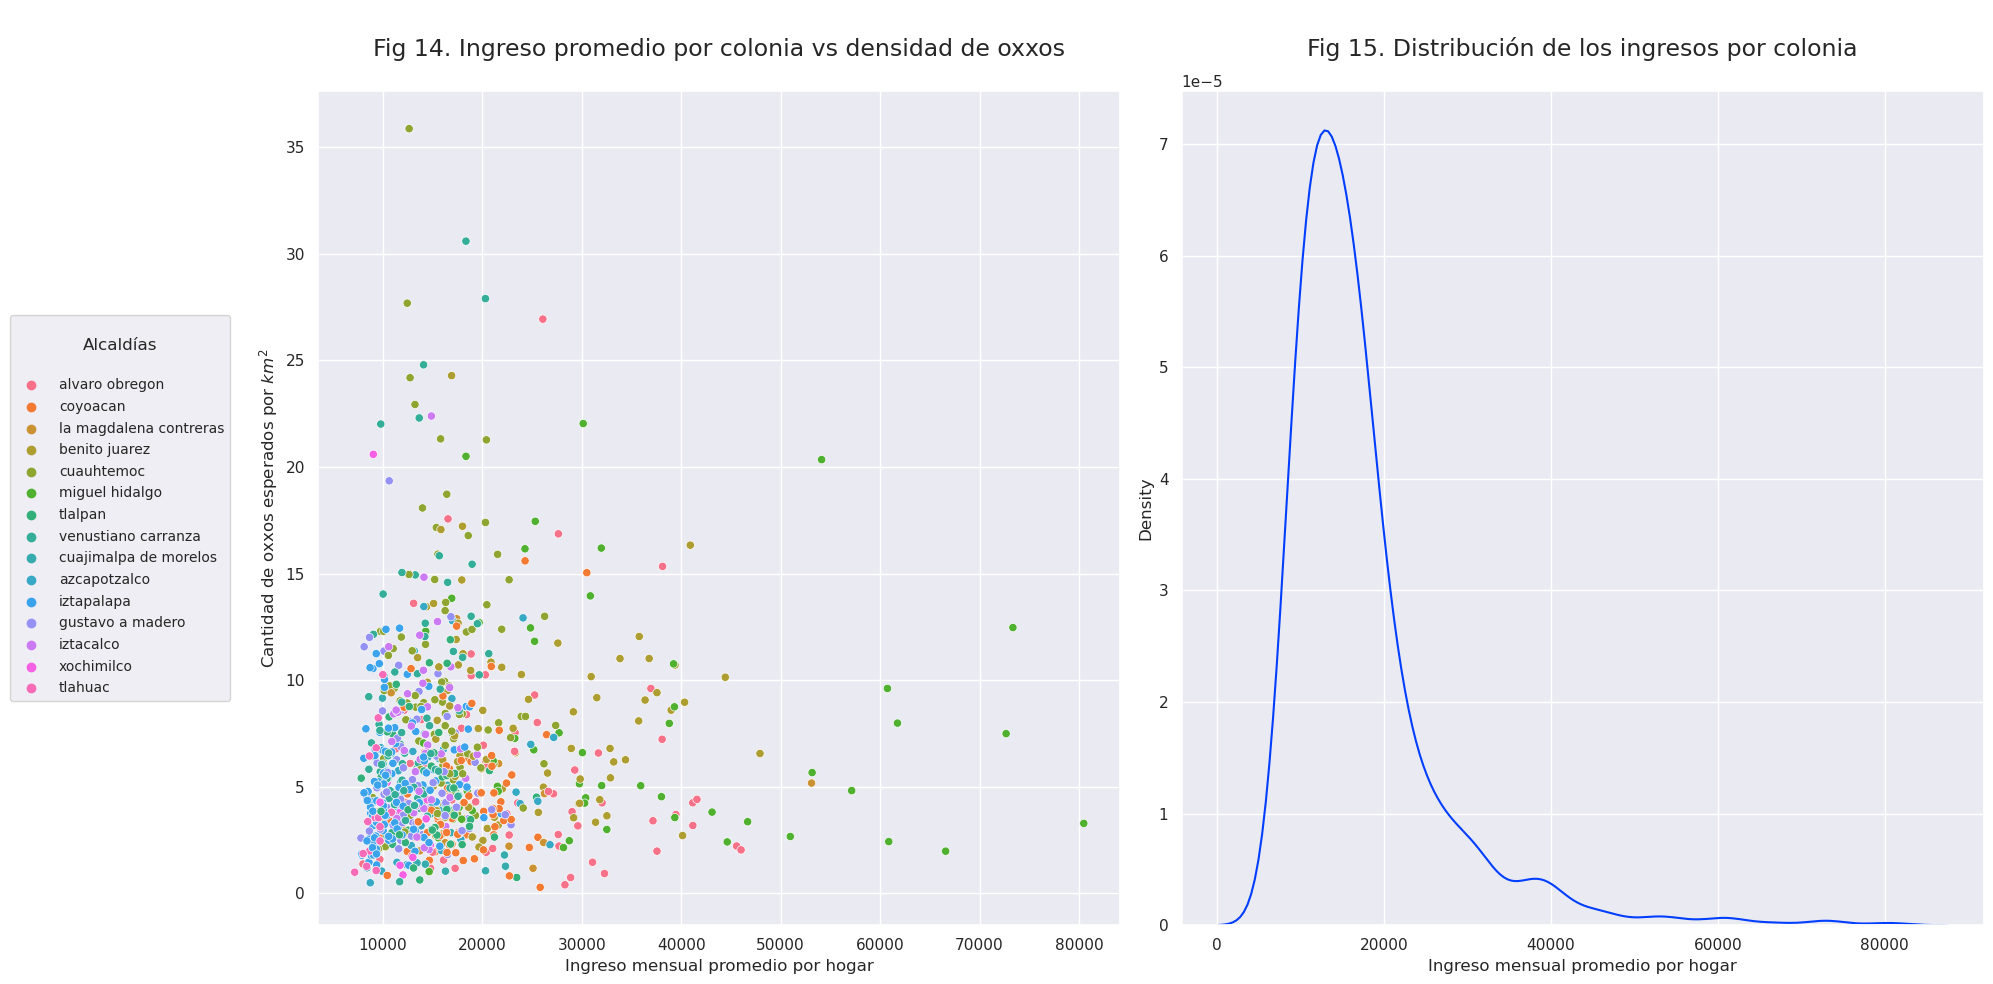

In [45]:
fig, axis = plt.subplots(1, 2, figsize=(20,10))

sns.scatterplot(n_oxxo_neighborhoods,
                x="Ingreso mensual promedio por hogar",
                y="Cantidad de oxxos esperados por $km^2$", hue="boroughs_name",
                ax=axis[0])

axis[0].legend(loc="center right", bbox_to_anchor=(-0.1, 0.5), title="\nAlcaldías\n")
axis[0].set_title("\nFig 14. Ingreso promedio por colonia vs densidad de oxxos\n", fontsize=17)

sns.kdeplot(n_oxxo_neighborhoods["Ingreso mensual promedio por hogar"], ax=axis[1])

axis[1].set_title("\nFig 15. Distribución de los ingresos por colonia\n", fontsize=17)

plt.setp(axis[0].get_legend().get_texts(), fontsize='10')
plt.tight_layout()
plt.show()

No parece haber una clara tendencia en cuanto a la densidad de oxxos por $km^2$ y el ingreso mensual promedio por hogar. Si bien se ve una clara acumulación de puntos por debajo de un ingreso de 30,000 pesos mexicanos, recordemos que es debido a que la mayoría de la población tiene ingresos en éste rango, como lo mostrado por la distribución del ingreso en la *Fig.15*. Por ende, mayor cantidad de puntos se ven representados aquí. En cambio, nota que si miramos de abajo hacia arriba para cualquier ingreso, la cantidad de oxxos por $km^2$ van más o menos por el mismo rango. 

Un análisis más profundo de éstos datos podría hacerse para saber si realmente hay una diferencia significativa en diferentes niveles de ingreso.